## Global Black Box Optimization with RNNS

In [1]:
import tensorflow as tf
import numpy as np
import visualize as viz
import benchmarkfunctions as bf

In [2]:
def kernel(x1,x2):
    return np.exp(-1.0/l**2*np.sum((np.expand_dims(x1,axis=2) - np.expand_dims(x2,axis=1))**2, axis = 3))

def GP(X,A,x):
    k_xX = kernel(x,X)
    return np.squeeze(np.matmul(k_xX,  A),axis=(2,))

def kernelTF(x1,x2):
    return tf.exp(-1.0/l**2*tf.reduce_sum((tf.expand_dims(x1,axis=2) - tf.expand_dims(x2,axis=1))**2, axis = 3))

def GPTF(X,A,x):
    k_xX = kernelTF(tf.expand_dims(x, axis = 1),X)
    return tf.squeeze(tf.matmul(k_xX,  A),axis=(2,))

def normalize(minv, maxv, y):
    return 2*(y-minv)/(maxv-minv)-1.0

In [3]:
def gen_data(n_train, n_test, dim, n_bumps, n_mc_samples = 100):
    X = np.random.uniform(low = -1.0, high = 1.0, size = (n_train+n_test, n_bumps, dim))
    Y = np.random.uniform(low = -1.0, high = 1.0, size = (n_train+n_test, n_bumps))

    K_XX = kernel(X,X)
    A = np.linalg.solve(K_XX, np.expand_dims(Y,axis=2))
    
    mc_samples = np.random.uniform(low = -1.0, high = 1.0, size = [1, n_mc_samples, dim])
    y = GP(X,A,mc_samples)

    min_vals = np.min(y, axis = 1).reshape(n_train+n_test,1)
    max_vals = np.max(y, axis = 1).reshape(n_train+n_test,1)

    return (X[:n_train], A[:n_train], min_vals[:n_train], max_vals[:n_train],\
            X[-n_test:], A[-n_test:], min_vals[-n_test:], max_vals[-n_test:])

In [4]:
def lstm_model(f, cell, weights):
    
    x_0 = -0.0*tf.ones([size, dim])
    h_0 = tf.ones([size, n_hidden])
    c_0 = tf.ones([size, n_hidden])
    
    state = (c_0, h_0)
    x = x_0
    y = f(x)+stddev*tf.random_normal([size, 1])
    samples_x = [x]
    samples_y = [y]

    for i in range(n_steps):
        h, state = cell(tf.concat([x, y], 1), state, scope='rnn_cell')
        x = tf.tanh(tf.matmul(h, weights['W_x']) + weights['b_x'])
        y = f(x)+stddev*tf.random_normal([size, 1])
        
        samples_x.append(x)
        samples_y.append(y)
    
    return samples_x, samples_y

In [5]:
def train_model(epochs, batch_size, log = True, verbose = True):
    
    if log:
        train_loss_list = []
        test_loss_list = []
        train_fmin_list = []
        test_fmin_list = []
    
    if verbose:
        print("Function Dimension: \t\t"+str(dim))
        print("Number of Training Samples: \t"+str(n_train))
        print("Number of Test Samples: \t"+str(n_test))
        print("Batch size: \t\t\t"+str(batch_size))
        print("Number of hidden Units: \t"+str(n_hidden))
        print("Sequence length: \t\t"+ str(n_steps))
        print("Noise in Observation: \t\t"+ str(stddev))
        print("Loss-Function: \t\t\t" + loss_type)
        print("Epochs: \t\t\t"+str(epochs))
        print("Learning rate init: \t\t"+str(rate_init))
        print("Learning rate decay: \t\t"+str(rate_decay))
        print("------------------------------------------------------------------------------------")

    learning_rate = rate_init
    for ep in range(epochs):
        learning_rate *= rate_decay
        
        for batch in range(n_train//batch_size):
            X_batch = X_train[batch*batch_size:(batch+1)*batch_size]
            A_batch = A_train[batch*batch_size:(batch+1)*batch_size]
            min_batch = min_train[batch*batch_size:(batch+1)*batch_size]
            max_batch = max_train[batch*batch_size:(batch+1)*batch_size]

            sess.run([train_step],\
                     feed_dict={Xt: X_batch, At: A_batch, mint: min_batch, maxt: max_batch,\
                                rate: learning_rate, size: X_batch.shape[0]})

        if log:
            train_loss, train_fmin = sess.run([loss, f_min], feed_dict=\
                                              {Xt: X_train, At: A_train, mint: min_train, maxt: max_train, size: n_train})
            test_loss, test_fmin = sess.run([loss, f_min], feed_dict=\
                                              {Xt: X_test, At: A_test, mint: min_test, maxt: max_test, size:n_test})
            train_loss_list += [train_loss]
            test_loss_list += [test_loss]
            train_fmin_list += [train_fmin]
            test_fmin_list += [test_fmin]

        if log and verbose and (ep < 10 or ep % (epochs // 10) == 0 or ep == epochs-1):
            print("Ep: " +"{:4}".format(ep)+" | TrainLoss: "+"{: .3f}".format(train_loss)
                  +" | TrainMin: "+ "{: .3f}".format(train_fmin)+ " | TestLoss: "+
                  "{: .3f}".format(test_loss)+" | TestMin: "+ "{: .3f}".format(test_fmin))
    
    print("Done.")
    if log:
        return (train_loss_list, test_loss_list, train_fmin_list, test_fmin_list)
    return None

In [24]:
# Data
dim = 2
n_train = 1600
n_test = 160
n_bumps = 3
l = 1/n_bumps*np.sqrt(dim)
n_mc_samples = 1000

# LSTM Model
n_hidden = 50
n_steps = 10

# Optimization
epochs = 1000

rate_init = 0.001
rate_final = 0.00001
rate_decay = (rate_final/rate_init)**(1/epochs)
batch_size = 128
stddev = 0.00
loss_type = ["MIN", "SUM", "WSUM", "EI"][1]

# Visualization
visualize = True

In [10]:
X_train, A_train, min_train, max_train, X_test, A_test, min_test, max_test = \
                                    gen_data(n_train, n_test, dim, n_bumps, n_mc_samples)

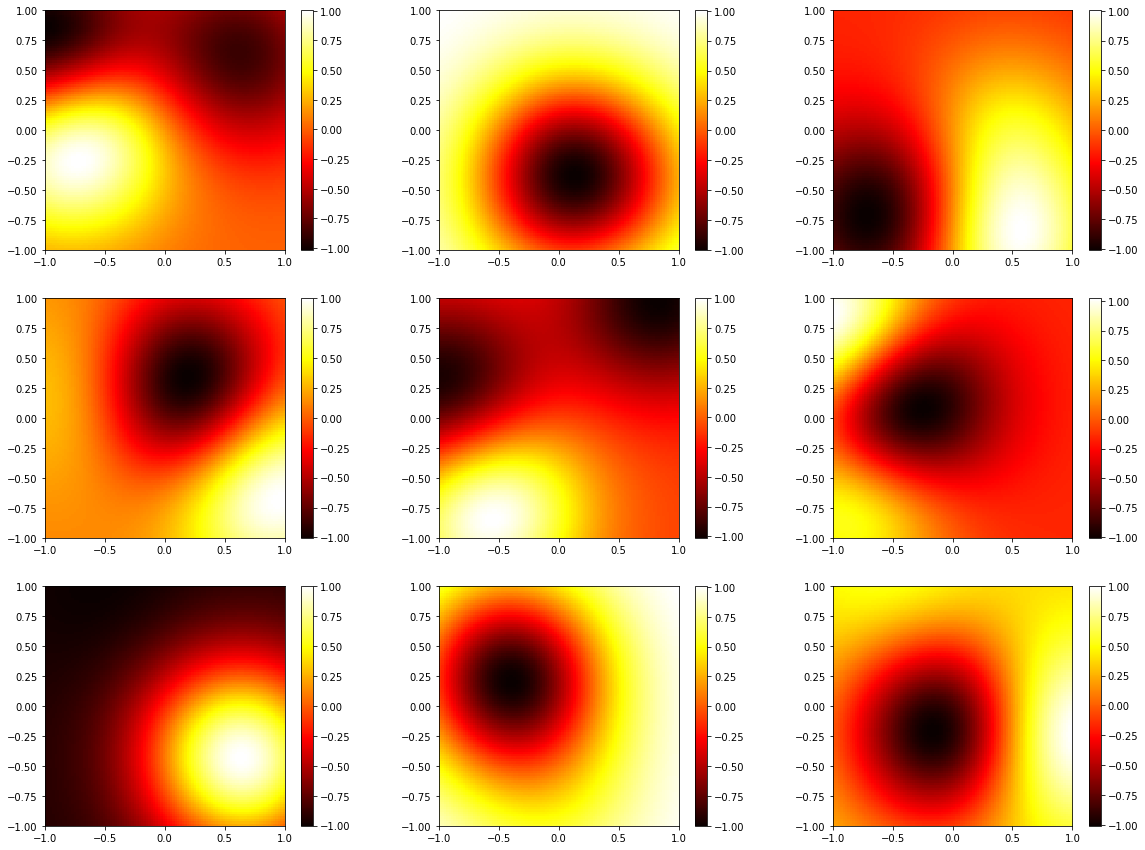

In [11]:
# Visualize Training Data
if visualize:
    nplot = 9
    idx = np.random.choice(list(range(n_train)), nplot)
    f_plot = lambda x: normalize(min_train[idx], max_train[idx], GP(X_train[idx], A_train[idx], x)) 
    viz.plot_training_data(f_plot, dim, nplot, heat = True)

In [12]:
# Create Model
size = tf.placeholder(tf.int32,[])

Xt = tf.placeholder(tf.float32, [None, n_bumps, dim])
At = tf.placeholder(tf.float32, [None, n_bumps, 1])
mint = tf.placeholder(tf.float32, [None, 1])
maxt = tf.placeholder(tf.float32, [None, 1])

f = lambda x: normalize(mint, maxt, GPTF(Xt, At, x)) 

# Create LSTM cell
cell = tf.contrib.rnn.LSTMCell(num_units = n_hidden, reuse=None)
cell(tf.zeros([size, dim +1]), (tf.zeros([size, n_hidden]),tf.zeros([size, n_hidden])), scope='rnn_cell')
cell = tf.contrib.rnn.LSTMCell(num_units = n_hidden, reuse=True)

# Create output weights
weights = {
    'W_x': tf.Variable(tf.random_normal([n_hidden, dim])),
    'b_x': tf.Variable(tf.random_normal([dim]))
}

samples_x, samples_y = lstm_model(f, cell, weights)

In [13]:
f_min = tf.reduce_mean(tf.reduce_min(samples_y, axis = 0))

loss_dict = {"MIN" : lambda x : tf.reduce_mean(tf.reduce_min(x, axis = 0)), 
             "SUM" : lambda x : tf.reduce_mean(tf.reduce_sum(x, axis = 0)),
             "WSUM" : lambda x : \
             tf.reduce_mean(tf.reduce_sum(tf.multiply(x, np.linspace(1/(n_steps+1),1, n_steps+1)), axis = 0)),
             "EI" : lambda x : tf.reduce_mean(tf.reduce_sum(x, axis = 0)) -\
                               tf.reduce_mean(tf.reduce_sum([tf.reduce_min(x[:i+1],\
                               axis = 0) for i in range(n_steps)], axis = 0))
            }
loss = loss_dict[loss_type](samples_y)

In [14]:
rate = tf.placeholder(tf.float32, [])
train_step = tf.train.AdamOptimizer(rate).minimize(loss)

In [25]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [26]:
train_logs = train_model(epochs, batch_size)

Function Dimension: 		2
Number of Training Samples: 	1600
Number of Test Samples: 	160
Batch size: 			128
Number of hidden Units: 	50
Sequence length: 		10
Noise in Observation: 		0.0
Loss-Function: 			SUM
Epochs: 			1000
Learning rate init: 		0.001
Learning rate decay: 		0.995405417351527
------------------------------------------------------------------------------------
Ep:    0 | TrainLoss: -1.759 | TrainMin: -0.601 | TestLoss: -1.777 | TestMin: -0.572
Ep:    1 | TrainLoss: -2.345 | TrainMin: -0.642 | TestLoss: -2.168 | TestMin: -0.610
Ep:    2 | TrainLoss: -2.533 | TrainMin: -0.582 | TestLoss: -2.025 | TestMin: -0.530
Ep:    3 | TrainLoss: -2.470 | TrainMin: -0.587 | TestLoss: -1.740 | TestMin: -0.528
Ep:    4 | TrainLoss: -2.944 | TrainMin: -0.650 | TestLoss: -2.551 | TestMin: -0.610
Ep:    5 | TrainLoss: -2.691 | TrainMin: -0.611 | TestLoss: -2.362 | TestMin: -0.576
Ep:    6 | TrainLoss: -3.048 | TrainMin: -0.630 | TestLoss: -2.408 | TestMin: -0.572
Ep:    7 | TrainLoss: -3.169 

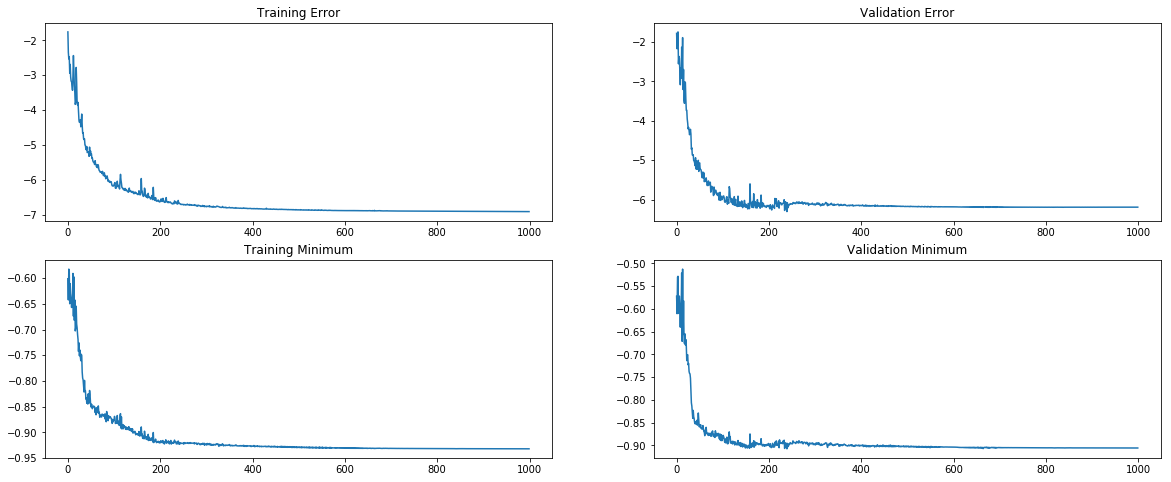

In [27]:
viz.visualize_learning(train_logs)

## Evaluate on Training/Test Data

In [28]:
# Extract Samples
samples_train = sess.run([samples_x], feed_dict={Xt: X_train, At: A_train, size : n_train, mint: min_train, maxt: max_train})
samples_train = np.array(samples_train[0]).reshape(n_steps+1,n_train, dim).transpose((1,0,2))
samples_test = sess.run([samples_x], feed_dict={Xt: X_test, At: A_test, size : n_test, mint: min_test, maxt: max_test})
samples_test = np.array(samples_test[0]).reshape(n_steps+1,n_test, dim).transpose((1,0,2))

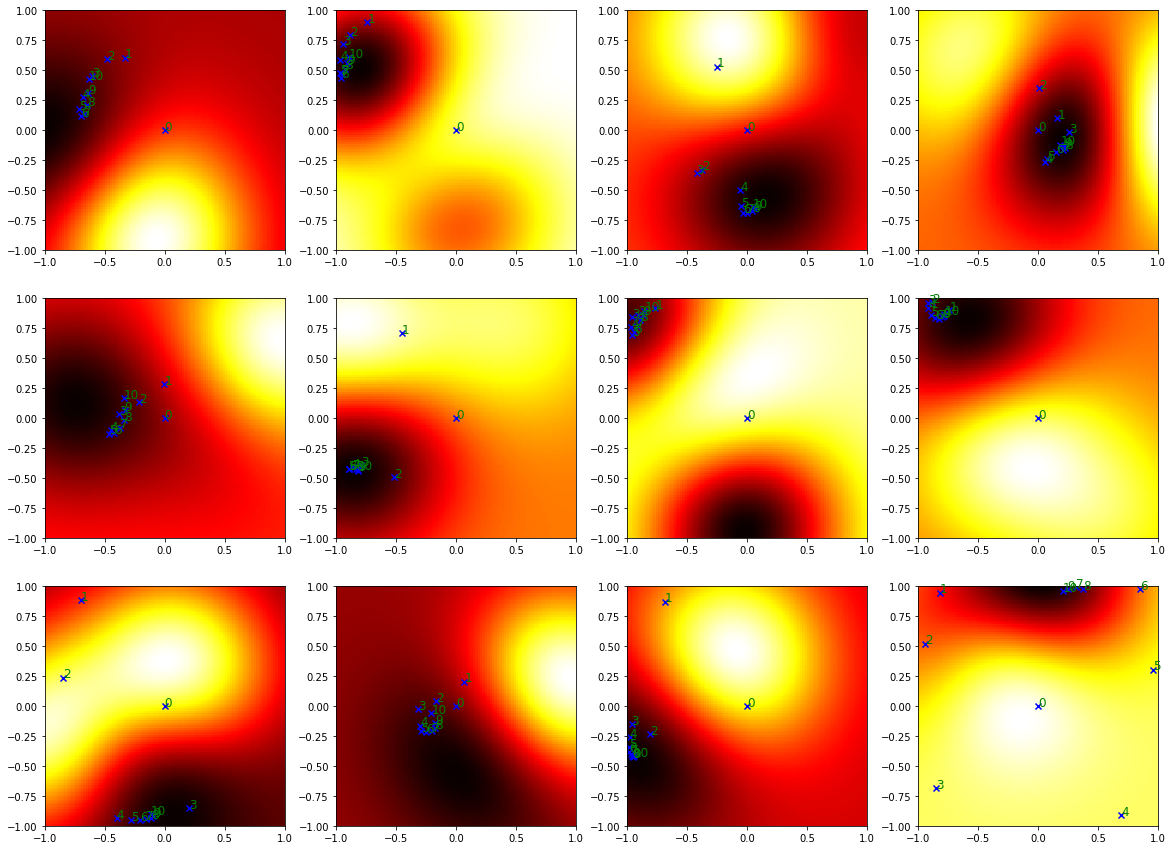

In [29]:
# Show results on Training Data
if visualize:
    nplot = 12
    idx = np.random.choice(list(range(n_train)), nplot)
    f_plot = lambda x: normalize(min_train[idx], max_train[idx], GP(X_train[idx], A_train[idx], x)) 
    viz.plot_result(f_plot, dim, nplot, samples_train[idx])

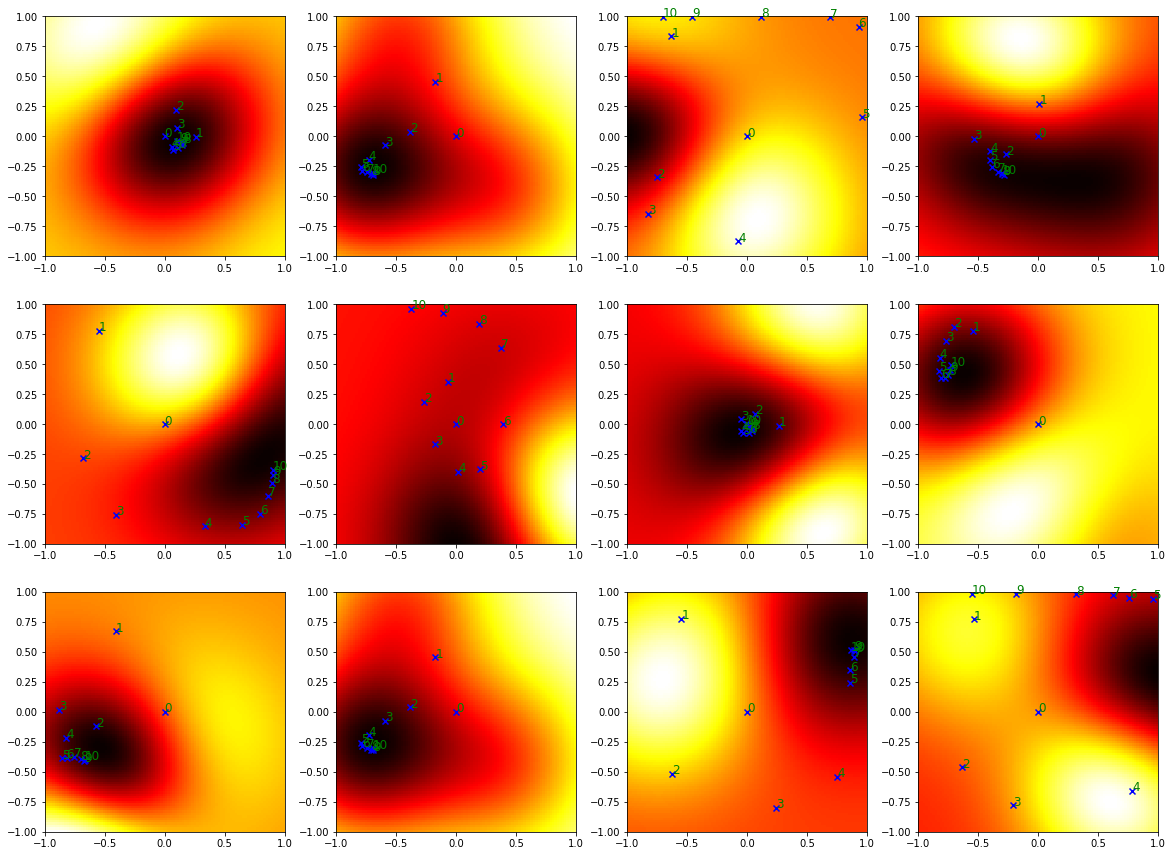

In [30]:
# Show results on Test Data
if visualize:
    nplot = 12
    idx = np.random.choice(list(range(n_test)), nplot)
    f_plot = lambda x: normalize(min_test[idx], max_test[idx], GP(X_test[idx], A_test[idx], x)) 
    viz.plot_result(f_plot, dim, nplot, samples_test[idx])

## Evaluate on Benchmark Function

In [34]:
f_bm = [bf.branin, bf.goldstein_price][1]
f_bm_tf = [bf.branin_tf, bf.goldstein_price_tf][1]

In [35]:
samples_benchmark_x, _ = sess.run(lstm_model(f_bm_tf, cell, weights), feed_dict={size: 1})
samples_benchmark_x = np.array(samples_benchmark_x).reshape(n_steps+1,1, dim).transpose((1,0,2))

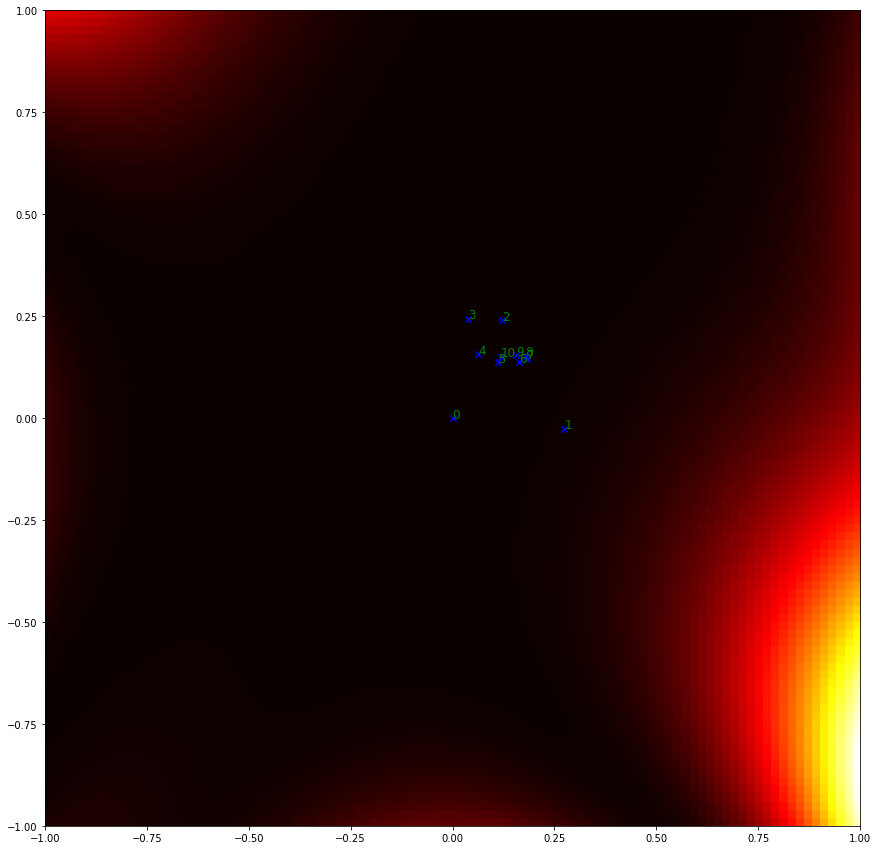

In [36]:
viz.plot_result(f_bm, 2, 1, samples_benchmark_x)